In [1]:
from advtopo import utils
import pickle
import numpy as np
from scipy.stats import norm
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
import seaborn as sns
from gudhi import bottleneck_distance as bottleneck_distance
import gudhi.wasserstein as wasserstein

In [2]:
dirPath = "./data/"

# We only use L from here, the one-hot encoded labels
diags_dict, F, L = utils.load_data("ORBIT5K", path_dataset=dirPath)

# D is preprocessed as in Perslay
with open(dirPath + 'processed_D.pkl', 'rb') as f:
    D = pickle.load(f)

/Users/Jens/Library/Caches/pypoetry/virtualenvs/advtopo-ZyCp4tIF-py3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [3]:
def getBarLengths(classes_chosen, w_p, H, density, mu, sigma, limit, y):

  barLengths = []
  ys = []

  


  for i, dg in enumerate(D[H]):
    if density:
      barLengths.append(np.sort(norm.cdf(dg[:,1], loc=mu, scale=sigma) - norm.cdf(dg[:,0], loc=mu, scale=sigma)))
    else:
      barLengths.append(np.sort(dg[:,1] - dg[:,0]))

    ys.append(y[i])

    

  if w_p != np.inf:

    barLengths2 = []

    for b in barLengths:
      barLengths2.append(np.cumsum(b ** w_p) ** (1 / w_p))

    barLengths = barLengths2

  ys = np.array(ys)

  #subsampling
  if limit:
    random_inds = np.random.choice(1000, size=limit, replace=False)

  barLengths = np.vstack(barLengths)



  return barLengths, ys

In [4]:
def getBarLengths(classes_chosen, w_p, H, density, mu, sigma, limit, y):

  barLengths = []
  ys = []
  random_inds = np.sort(np.random.choice(1000, size=limit, replace=False))
  #random_inds = list(range(limit))

  for c in classes_chosen:

    #for dg in diagrams[y==c][:limit,:]:
    for dg in D[H][y==c][random_inds]:
      if density:
        barLengths.append(np.sort(norm.cdf(dg[:,1], loc=mu, scale=sigma) - norm.cdf(dg[:,0], loc=mu, scale=sigma)))
      else:
        barLengths.append(np.sort(dg[:,1] - dg[:,0]))

      ys.append(c)

  sizes = [len(i) for i in barLengths]

  if w_p != np.inf:

    barLengths2 = []

    for b in barLengths:
      barLengths2.append(np.cumsum(b ** w_p) ** (1 / w_p))

    barLengths = barLengths2

  ys = np.array(ys)

  barLengths = np.vstack(barLengths)

  return barLengths, ys

In [5]:
(np.sort(np.random.choice(1000, size=1000, replace=False))==np.sort(np.array(list(range(1000))))).all()

True

In [ ]:
random_inds = np.random.choice(1000, size=limit, replace=False)

In [7]:
np.unique(D[H][y==0][random_inds][:,0,0])

NameError: name 'H' is not defined

In [8]:
dg = D[1][0]

In [9]:
dg

array([[0.00771445, 0.06690148, 1.        ],
       [0.02069931, 0.05096209, 1.        ],
       [0.0061209 , 0.0299975 , 1.        ],
       ...,
       [0.00723244, 0.00743928, 1.        ],
       [0.00142645, 0.00162898, 1.        ],
       [0.00399433, 0.00419467, 1.        ]], dtype=float32)

In [10]:
H = 1
w_p = np.inf

density = True
mu = 0.15
sigma = 0.02

limit = 1000

classes_chosen = [0, 1, 2, 3, 4]

y = np.argmax(L, axis=1)

In [11]:
barLengths0, ys = getBarLengths(classes_chosen, w_p, 0, False, mu, sigma, limit, y)
barLengths1, ys = getBarLengths(classes_chosen, w_p, 1, False, mu, sigma, limit, y)
barLengths1_2, ys = getBarLengths(classes_chosen, w_p, 1, density, mu, sigma, limit, y)
barLengths1_3, ys = getBarLengths(classes_chosen, w_p, 1, density, 0.2, sigma, limit, y)
barLengths1_4, ys = getBarLengths(classes_chosen, w_p, 1, density, 0.1, sigma, limit, y)

barLengthsToStack = [barLengths0, barLengths1, barLengths1_2, barLengths1_3, barLengths1_4]

In [12]:
barLengths0.shape

(5000, 500)

In [13]:
X = np.hstack(barLengthsToStack)


In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, ys, test_size=0.2, random_state=42)

In [15]:
clf = make_pipeline(StandardScaler(), SVC(gamma='auto'))
clf.fit(X_train, y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('svc', SVC(gamma='auto'))])

In [16]:
pred = clf.predict(X_test)

accTest = accuracy_score(y_test, pred)

print("Accuracy test", accTest)

Accuracy test 0.746


<Axes: >

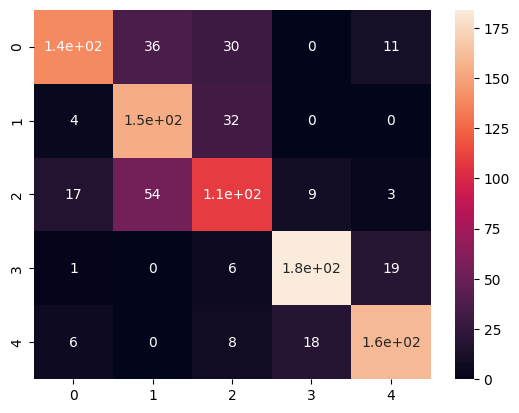

In [17]:
cfm = confusion_matrix(y_test, pred)
sns.heatmap(cfm, annot=True)

In [299]:
barLengths1.shape

(5000, 500)

In [365]:
n_false = 0
for ind1 in range(30, 33):
    for ind2 in range(30,33):

        bottleneck = bottleneck_distance(D[1][ind1][:,:2], D[1][ind2][:,:2])*2
        #bottleneck = wasserstein.wasserstein_distance(D[1][ind1][:,:2], D[1][ind2][:,:2], matching=False, order=5, internal_p=1)
        linf = np.linalg.norm(barLengths1[ind1] - barLengths1[ind2], ord=np.inf)

        print(ind1, ind2)
        print(bottleneck)
        print(linf)
        print(bottleneck>=linf)

        if bottleneck<linf:
            n_false += 1


30 30
1.9785796757786973e-308
0.0
True
30 31
0.013644842430949211
0.0034220107
True
30 32
0.033481039106845856
0.022153378
True
31 30
0.013644842430949211
0.0034220107
True
31 31
1.8774869386106306e-308
0.0
True
31 32
0.03184324502944946
0.01930651
True
32 30
0.033481039106845856
0.022153378
True
32 31
0.03184324502944946
0.01930651
True
32 32
2.8425941942258964e-308
0.0
True


In [363]:
n_false

0

In [357]:
bottleneck_real = bottleneck_distance(D[1][0][:,:2], D[1][4][:,:2])
bottleneck = wasserstein.wasserstein_distance(D[1][0][:,:2], D[1][4][:,:2], matching=False, order=4, internal_p=1)
linf = np.linalg.norm(barLengths1[0] - barLengths1[4], ord=np.inf)

In [360]:
bottleneck_real*2

0.054087765514850616

In [356]:
bottleneck

0.04100851303406703

In [340]:
linf

0.039886914